<a href="https://colab.research.google.com/github/rachanashinde15/DemoGIt/blob/master/Resnet_Thesis_Final_3%20layeroutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import datasets,models,layers


In [11]:
# Adding TF Cifar10 Data ..
from keras.datasets import cifar100
(X_train, Y_train), (X_test, Y_test) = cifar100.load_data()

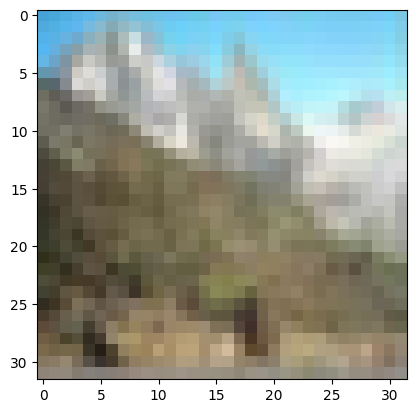

In [12]:
# Drawing sample . 
plt.imshow(X_train[42])

In [13]:
# Normalize the data.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)

In [15]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [16]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [17]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1 = ResnetBlock(64)
        self.res_2 = ResnetBlock(128, down_sample=True)
        self.res_3 = ResnetBlock(256, down_sample=True)
        self.res_4 = ResnetBlock(512, down_sample=True)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        # Group the consecutive residual blocks
        out = self.res_1(out)
        out = self.res_2(out)
        out = self.res_3(out)
        out = self.res_4(out)

        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [18]:
model = ResNet18(100)
model.build(input_shape = (None,32,32,3))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple              

In [19]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs=50, validation_data=(X_train, Y_train),callbacks=[es])

Epoch 1/50
157/156 [==============================] - ETA: 0s - loss: 3.6283 - accuracy: 0.1621

156/156 [==============================] - 44s 155ms/step - loss: 3.6283 - accuracy: 0.1621 - val_loss: 4.4004 - val_accuracy: 0.0908
Epoch 2/50
157/156 [==============================] - ETA: 0s - loss: 2.9324 - accuracy: 0.2732

156/156 [==============================] - 21s 134ms/step - loss: 2.9324 - accuracy: 0.2732 - val_loss: 3.4817 - val_accuracy: 0.1988
Epoch 3/50
157/156 [==============================] - ETA: 0s - loss: 2.6021 - accuracy: 0.3338

156/156 [==============================] - 22s 138ms/step - loss: 2.6021 - accuracy: 0.3338 - val_loss: 2.6095 - val_accuracy: 0.3317
Epoch 4/50
157/156 [==============================] - ETA: 0s - loss: 2.3458 - accuracy: 0.3867

156/156 [==============================] - 21s 133ms/step - loss: 2.3458 - accuracy: 0.3867 - val_loss: 2.5693 - val_accuracy: 0.3521
Epoch 5/50
157/156 [==============================] - ETA: 0s - loss: 2.1534 - accuracy: 0.4300

156/156 [==============================] - 22s 138ms/step - loss: 2.1534 - accuracy: 0.4300 - val_loss: 2.3160 - val_accuracy: 0.4007
Epoch 6/50
157/156 [==============================] - ETA: 0s - loss: 1.9794 - accuracy: 0.4690

156/156 [==============================] - 21s 135ms/step - loss: 1.9794 - accuracy: 0.4690 - val_loss: 1.9527 - val_accuracy: 0.4743
Epoch 7/50
157/156 [==============================] - ETA: 0s - loss: 1.8258 - accuracy: 0.5031

156/156 [==============================] - 21s 133ms/step - loss: 1.8258 - accuracy: 0.5031 - val_loss: 1.8469 - val_accuracy: 0.5017
Epoch 8/50
157/156 [==============================] - ETA: 0s - loss: 1.6871 - accuracy: 0.5372

156/156 [==============================] - 21s 137ms/step - loss: 1.6871 - accuracy: 0.5372 - val_loss: 2.2018 - val_accuracy: 0.4229
Epoch 9/50
157/156 [==============================] - ETA: 0s - loss: 1.5495 - accuracy: 0.5659

156/156 [==============================] - 21s 138ms/step - loss: 1.5495 - accuracy: 0.5659 - val_loss: 1.7104 - val_accuracy: 0.5336
Epoch 10/50
157/156 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.5967

156/156 [==============================] - 21s 132ms/step - loss: 1.4280 - accuracy: 0.5967 - val_loss: 1.3714 - val_accuracy: 0.6155
Epoch 11/50
157/156 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.6328

156/156 [==============================] - 22s 138ms/step - loss: 1.2922 - accuracy: 0.6328 - val_loss: 1.3199 - val_accuracy: 0.6195
Epoch 12/50
157/156 [==============================] - ETA: 0s - loss: 1.1755 - accuracy: 0.6642

156/156 [==============================] - 21s 133ms/step - loss: 1.1755 - accuracy: 0.6642 - val_loss: 1.1636 - val_accuracy: 0.6591
Epoch 13/50
157/156 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.6855

156/156 [==============================] - 21s 137ms/step - loss: 1.0771 - accuracy: 0.6855 - val_loss: 1.0275 - val_accuracy: 0.6968
Epoch 14/50
157/156 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.7222

156/156 [==============================] - 21s 135ms/step - loss: 0.9514 - accuracy: 0.7222 - val_loss: 1.5660 - val_accuracy: 0.5788
Epoch 15/50
157/156 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.7449

156/156 [==============================] - 21s 133ms/step - loss: 0.8613 - accuracy: 0.7449 - val_loss: 0.8940 - val_accuracy: 0.7351
Epoch 16/50
157/156 [==============================] - ETA: 0s - loss: 0.7676 - accuracy: 0.7706

156/156 [==============================] - 21s 135ms/step - loss: 0.7676 - accuracy: 0.7706 - val_loss: 0.9301 - val_accuracy: 0.7266
Epoch 17/50
157/156 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.7929

156/156 [==============================] - 21s 134ms/step - loss: 0.6876 - accuracy: 0.7929 - val_loss: 0.8966 - val_accuracy: 0.7326
Epoch 18/50
157/156 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.8150

156/156 [==============================] - 21s 131ms/step - loss: 0.6163 - accuracy: 0.8150 - val_loss: 0.7820 - val_accuracy: 0.7632
Epoch 19/50
157/156 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.8321

156/156 [==============================] - 22s 139ms/step - loss: 0.5512 - accuracy: 0.8321 - val_loss: 0.5504 - val_accuracy: 0.8295
Epoch 20/50
157/156 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.8556

156/156 [==============================] - 21s 135ms/step - loss: 0.4777 - accuracy: 0.8556 - val_loss: 0.4790 - val_accuracy: 0.8520
Epoch 21/50
157/156 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8665

156/156 [==============================] - 22s 138ms/step - loss: 0.4375 - accuracy: 0.8665 - val_loss: 0.5434 - val_accuracy: 0.8329
Epoch 22/50
157/156 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8747

156/156 [==============================] - 21s 137ms/step - loss: 0.4089 - accuracy: 0.8747 - val_loss: 0.4552 - val_accuracy: 0.8570
Epoch 23/50
157/156 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8868

156/156 [==============================] - 22s 141ms/step - loss: 0.3668 - accuracy: 0.8868 - val_loss: 0.5790 - val_accuracy: 0.8254
Epoch 24/50
157/156 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8917

156/156 [==============================] - 22s 138ms/step - loss: 0.3447 - accuracy: 0.8917 - val_loss: 0.2449 - val_accuracy: 0.9252
Epoch 25/50
157/156 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.9042

156/156 [==============================] - 21s 137ms/step - loss: 0.3091 - accuracy: 0.9042 - val_loss: 0.5146 - val_accuracy: 0.8424
Epoch 26/50
157/156 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.9035

156/156 [==============================] - 21s 133ms/step - loss: 0.3050 - accuracy: 0.9035 - val_loss: 0.4081 - val_accuracy: 0.8726
Epoch 27/50
157/156 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9161

156/156 [==============================] - 21s 137ms/step - loss: 0.2753 - accuracy: 0.9161 - val_loss: 0.4292 - val_accuracy: 0.8651
Epoch 28/50
157/156 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9177

156/156 [==============================] - 21s 137ms/step - loss: 0.2620 - accuracy: 0.9177 - val_loss: 0.3049 - val_accuracy: 0.9043
Epoch 29/50
157/156 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9191

156/156 [==============================] - 22s 138ms/step - loss: 0.2559 - accuracy: 0.9191 - val_loss: 0.6513 - val_accuracy: 0.8185
Epoch 30/50
157/156 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9244

156/156 [==============================] - 21s 137ms/step - loss: 0.2439 - accuracy: 0.9244 - val_loss: 0.2728 - val_accuracy: 0.9126
Epoch 31/50
157/156 [==============================] - ETA: 0s - loss: 0.1966 - accuracy: 0.9396

156/156 [==============================] - 21s 134ms/step - loss: 0.1966 - accuracy: 0.9396 - val_loss: 0.3695 - val_accuracy: 0.8848
Epoch 32/50
157/156 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9309

156/156 [==============================] - 22s 139ms/step - loss: 0.2204 - accuracy: 0.9309 - val_loss: 0.3448 - val_accuracy: 0.8892
Epoch 33/50
157/156 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9279

156/156 [==============================] - 21s 138ms/step - loss: 0.2243 - accuracy: 0.9279 - val_loss: 0.6945 - val_accuracy: 0.8099
Epoch 34/50
157/156 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9333

156/156 [==============================] - 21s 132ms/step - loss: 0.2106 - accuracy: 0.9333 - val_loss: 0.2536 - val_accuracy: 0.9187
Epoch 35/50
157/156 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9361

156/156 [==============================] - 22s 138ms/step - loss: 0.2024 - accuracy: 0.9361 - val_loss: 0.3261 - val_accuracy: 0.8961
Epoch 36/50
157/156 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9387

156/156 [==============================] - 22s 139ms/step - loss: 0.1938 - accuracy: 0.9387 - val_loss: 0.2493 - val_accuracy: 0.9197
Epoch 37/50
157/156 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9438

156/156 [==============================] - 22s 141ms/step - loss: 0.1811 - accuracy: 0.9438 - val_loss: 0.7484 - val_accuracy: 0.8146
Epoch 38/50
157/156 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9423

156/156 [==============================] - 21s 133ms/step - loss: 0.1767 - accuracy: 0.9423 - val_loss: 0.1767 - val_accuracy: 0.9448
Epoch 39/50
157/156 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9430

156/156 [==============================] - 21s 137ms/step - loss: 0.1749 - accuracy: 0.9430 - val_loss: 0.1476 - val_accuracy: 0.9520
Epoch 40/50
157/156 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9443

156/156 [==============================] - 21s 137ms/step - loss: 0.1736 - accuracy: 0.9443 - val_loss: 0.1806 - val_accuracy: 0.9422
Epoch 41/50
157/156 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9459

156/156 [==============================] - 22s 139ms/step - loss: 0.1705 - accuracy: 0.9459 - val_loss: 0.1689 - val_accuracy: 0.9478
Epoch 42/50
156/156 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9520

156/156 [==============================] - 22s 138ms/step - loss: 0.1466 - accuracy: 0.9520 - val_loss: 0.4017 - val_accuracy: 0.8843
Epoch 43/50
157/156 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9477

156/156 [==============================] - 21s 133ms/step - loss: 0.1632 - accuracy: 0.9477 - val_loss: 0.1968 - val_accuracy: 0.9360
Epoch 44/50
157/156 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9436

156/156 [==============================] - 22s 138ms/step - loss: 0.1733 - accuracy: 0.9436 - val_loss: 0.1988 - val_accuracy: 0.9360
Epoch 45/50
157/156 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9503

156/156 [==============================] - 22s 139ms/step - loss: 0.1545 - accuracy: 0.9503 - val_loss: 0.3429 - val_accuracy: 0.8931
Epoch 46/50
157/156 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9508

156/156 [==============================] - 21s 133ms/step - loss: 0.1505 - accuracy: 0.9508 - val_loss: 0.2550 - val_accuracy: 0.9197
Epoch 47/50
157/156 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9545

156/156 [==============================] - 22s 139ms/step - loss: 0.1403 - accuracy: 0.9545 - val_loss: 0.2002 - val_accuracy: 0.9379
Epoch 48/50
157/156 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9578

156/156 [==============================] - 22s 138ms/step - loss: 0.1290 - accuracy: 0.9578 - val_loss: 0.1029 - val_accuracy: 0.9661
Epoch 49/50
157/156 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9545

156/156 [==============================] - 21s 132ms/step - loss: 0.1386 - accuracy: 0.9545 - val_loss: 0.2199 - val_accuracy: 0.9310
Epoch 50/50
157/156 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.9509

156/156 [==============================] - 21s 137ms/step - loss: 0.1497 - accuracy: 0.9509 - val_loss: 0.1568 - val_accuracy: 0.9478


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


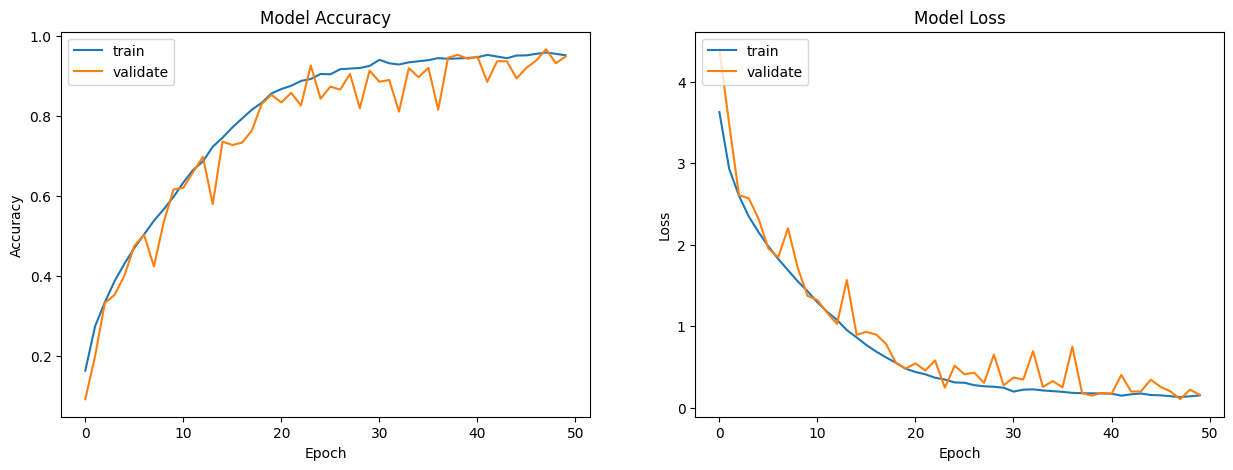

In [20]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [21]:

ModelLoss, ModelAccuracy = model.evaluate(X_train, Y_train)

print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy))

1250/1250 [==============================] - 6s 5ms/step - loss: 0.1568 - accuracy: 0.9478
Model Loss is 0.15683023631572723
Model Accuracy is 0.9477750062942505
